In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
from scipy.stats.distributions import t as scp_t
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from sqlalchemy import create_engine, Column, String, Integer, Boolean, MetaData, Table, case, between, ForeignKey
from sqlalchemy.orm import mapper, create_session, relationship
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.ext.automap import automap_base
import sqlalchemy.types as types
from sqlalchemy.sql import select, and_, or_, not_, func
from TPAR import PARfxns as pf, loadDataFRP as FRP, loadSTRATOGEM as STRAT
from TPAR import mplRC
#mplRC.slidesRC();
%matplotlib inline

mpl default settings: fs=16, lw=1, ms=8


# Relationship between turbidity, chlorophyll, and beam transmission
Goal: estimate turbidity from STRATOGEM data

#### load FRP data

In [2]:
dfall=FRP.loadFlat(exp='all',sel='wide',dp=1.0,qc=False)
dfall.rename(columns={'turb':'NTU'},inplace=True)
dfall[['sta','xmiss','cX','Date','prSM','wetStar','NTU']].head()

,sta,xmiss,cX,Date,prSM,wetStar,NTU
0,1.0,2.931728,14.118313,20170410,1.0,NaN,22.221587
1,1.0,2.935879,14.112653,20170410,2.0,NaN,22.476984
2,1.0,2.937265,14.110766,20170410,3.0,NaN,22.573587
3,1.0,3.030783,13.985397,20170410,4.0,NaN,22.529585
4,1.0,3.033497,13.981816,20170410,5.0,NaN,22.438194


In [3]:
df0, zCasts=FRP.loadDataFRP(exp='all',sel='wide',dp=1.0)
dfall2=FRP.flattenCastsDict(zCasts)
dfall2.rename(columns={'turb':'NTU'},inplace=True)
dfall2['cX']=FRP.cXfromX(dfall2['xmiss']) 
dfall2[['sta','xmiss','cX','prSM','wetStar','NTU']].head()

,sta,xmiss,cX,prSM,wetStar,NTU
0,1.0,2.931728,14.118313,1.0,NaN,22.221587
1,1.0,2.935879,14.112653,2.0,NaN,22.476984
2,1.0,2.937265,14.110766,3.0,NaN,22.573587
3,1.0,3.030783,13.985397,4.0,NaN,22.529585
4,1.0,3.033497,13.981816,5.0,NaN,22.438194


In [4]:
np.max(np.abs(dfall['cX']-dfall2['cX']))

0.0

In [5]:
xrange=[94,95,95.2,95.4,95.6,95.8,96,100]

In [6]:
for xm in xrange:
    dfall['xmiss_os'+str(xm)]=dfall['xmiss']
    pf.xmissQCFlat(dfall,groupingvar='Date',castvar='castid',depthvar='prSM',xmissvar='xmiss_os'+str(xm),xmax=xm)
    dfall['cX_os'+str(xm)]=FRP.cXfromX(dfall['xmiss_os'+str(xm)])

load SSG
20170410 -2.1123669580874207
20170531 -1.4510541090543256
20171101 0.5387241569942773
20170410 -1.1123669580874207
20170531 -0.45105410905432564
20171101 1.5387241569942773
20170410 -0.9123669580874179
20170531 -0.2510541090543228
20171101 1.7387241569942802
20170410 -0.712366958087415
20170531 -0.05105410905431995
20171101 1.938724156994283
20170410 -0.5123669580874264
20170531 0.14894589094566868
20171101 2.1387241569942717
20170410 -0.31236695808742354
20170531 0.3489458909456715
20171101 2.3387241569942745
20170410 -0.1123669580874207
20170531 0.5489458909456744
20171101 2.5387241569942773
20170410 3.8876330419125793
20170531 4.548945890945674
20171101 6.538724156994277


In [6]:
np.max(np.abs(dfall['xmiss']-dfall2['xmiss']))

0.0

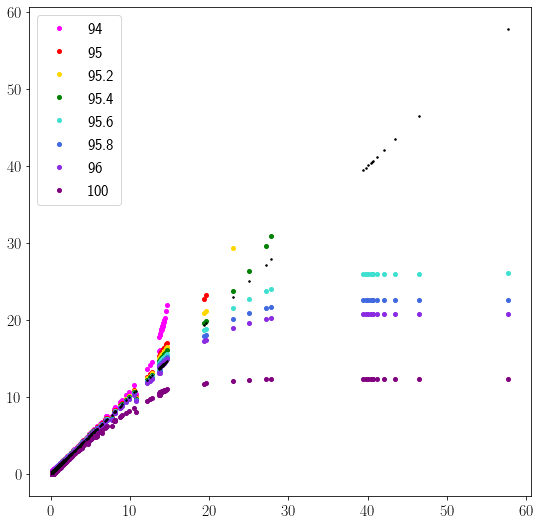

In [7]:
fig,ax=plt.subplots(1,1,figsize=(9,9))
cols='magenta','red','gold','green','turquoise','royalblue','blueviolet','purple'
ii=0
for xm in xrange:
    ax.plot(dfall['cX'],dfall['cX_os'+str(xm)],'.',color=cols[ii],label=xm)
    ii+=1
ax.plot(dfall['cX'],dfall['cX'],'k.',ms=3)
ax.legend()

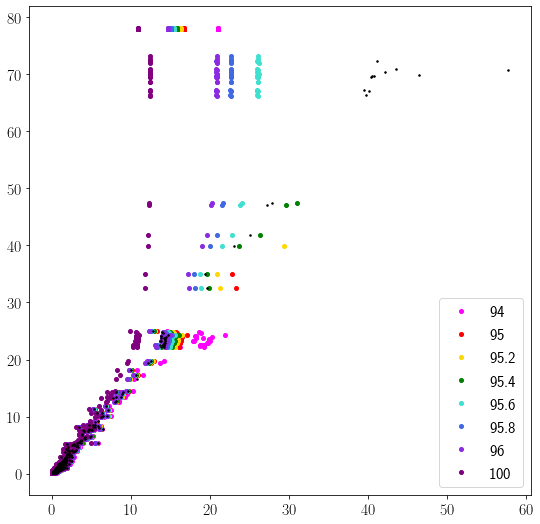

In [11]:
fig,ax=plt.subplots(1,1,figsize=(9,9))
cols='magenta','red','gold','green','turquoise','royalblue','blueviolet','purple'
ii=0
for xm in xrange:
    ax.plot(dfall['cX_os'+str(xm)],dfall['NTU'],'.',color=cols[ii],label=xm)
    ii+=1
ax.plot(dfall['cX'],dfall['NTU'],'k.',ms=3)
ax.legend()

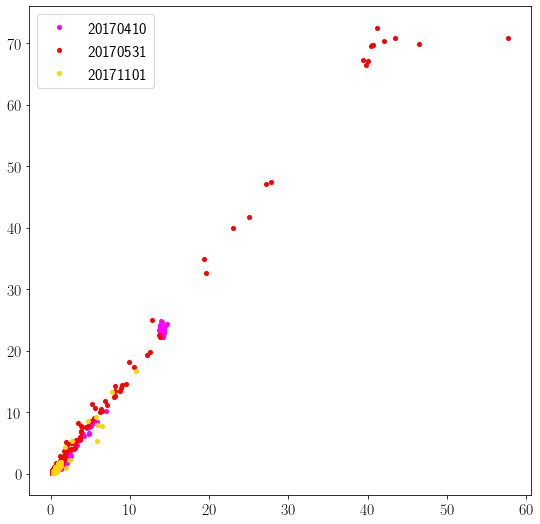

In [16]:
fig,ax=plt.subplots(1,1,figsize=(9,9))
cols='magenta','red','gold','green','turquoise','royalblue','blueviolet','purple'
ii=0
for idd in np.unique(dfall['Date']):
    ax.plot(dfall.loc[dfall.Date==idd,['cX']],dfall.loc[dfall.Date==idd,['NTU']],'.',color=cols[ii],label=idd)
    ii+=1
ax.legend()

In [8]:
dfall.keys()

Index(['prSM', 'gsw_ctA0', 'gsw_srA0', 'xmiss', 'par', 'wetStar', 'sbeox0ML_L',
       'seaTurbMtrnoQC', 'turb_uncor', 'NTU', 'CStarTr0', 'wetStar19', 'isup',
       'sta', 'castid', 'Station', 'Date', 'Lat', 'Lon', 'cX', 'xmiss_os94',
       'Bathy', 'cX_os94', 'xmiss_os95', 'cX_os95', 'xmiss_os95.2',
       'cX_os95.2', 'xmiss_os95.4', 'cX_os95.4', 'xmiss_os95.6', 'cX_os95.6',
       'xmiss_os95.8', 'cX_os95.8', 'xmiss_os96', 'cX_os96', 'xmiss_os100',
       'cX_os100'],
      dtype='object')

In [9]:
xmlist=[i for i in dfall.keys() if i.startswith('xmiss_')]
cxlist=[i for i in dfall.keys() if i.startswith('cX_')]

In [10]:
dfall.loc[dfall.sta==18,['sta','prSM','NTU','xmiss','cX']+xmlist+cxlist]

,sta,prSM,NTU,xmiss,cX,xmiss_os94,xmiss_os95,xmiss_os95.2,xmiss_os95.4,xmiss_os95.6,...,xmiss_os96,xmiss_os100,cX_os94,cX_os95,cX_os95.2,cX_os95.4,cX_os95.6,cX_os95.8,cX_os96,cX_os100
2250,18.0,1.0,67.064074,-0.002621,NaN,-1.453675,-0.453675,-0.253675,-0.053675,0.146325,...,0.546325,4.546325,NaN,NaN,NaN,NaN,26.108390,22.662195,20.838848,12.363404
2251,18.0,2.0,67.084624,0.004463,40.068289,-1.446591,-0.446591,-0.246591,-0.046591,0.153409,...,0.553409,4.553409,NaN,NaN,NaN,NaN,25.919271,22.581197,20.787312,12.357176
2252,18.0,3.0,66.213782,-0.000048,NaN,-1.451102,-0.451102,-0.251102,-0.051102,0.148898,...,0.548898,4.548898,NaN,NaN,NaN,NaN,26.038661,22.632585,20.820053,12.361141
2253,18.0,4.0,66.441633,0.004782,39.792142,-1.446272,-0.446272,-0.246272,-0.046272,0.153728,...,0.553728,4.553728,NaN,NaN,NaN,NaN,25.910962,22.577588,20.785007,12.356896
2254,18.0,5.0,67.293399,0.005238,39.428047,-1.445816,-0.445816,-0.245816,-0.045816,0.154184,...,0.554184,4.554184,NaN,NaN,NaN,NaN,25.899121,22.572438,20.781717,12.356495
2255,18.0,6.0,68.559084,-0.002000,NaN,-1.453054,-0.453054,-0.253054,-0.053054,0.146946,...,0.546946,4.546946,NaN,NaN,NaN,NaN,26.091436,22.655023,20.834300,12.362857
2256,18.0,7.0,69.585660,0.004100,40.407739,-1.446954,-0.446954,-0.246954,-0.046954,0.153046,...,0.553046,4.553046,NaN,NaN,NaN,NaN,25.928750,22.585309,20.789938,12.357495
2257,18.0,8.0,69.488399,-0.001534,NaN,-1.452588,-0.452588,-0.252588,-0.052588,0.147412,...,0.547412,4.547412,NaN,NaN,NaN,NaN,26.078780,22.649658,20.830896,12.362448
2258,18.0,9.0,70.093435,-0.003863,NaN,-1.454917,-0.454917,-0.254917,-0.054917,0.145083,...,0.545083,4.545083,NaN,NaN,NaN,NaN,26.142469,22.676558,20.847947,12.364497
2259,18.0,10.0,70.424395,0.002693,42.088460,-1.448361,-0.448361,-0.248361,-0.048361,0.151639,...,0.551639,4.551639,NaN,NaN,NaN,NaN,25.965683,22.601278,20.800124,12.358731


In [10]:
dfall2.loc[dfall2.sta==18,['sta','prSM','NTU','xmiss','cX']]

,sta,prSM,NTU,xmiss,cX
2250,18.0,1.0,67.064074,-0.002621,NaN
2251,18.0,2.0,67.084624,0.004463,40.068289
2252,18.0,3.0,66.213782,-0.000048,NaN
2253,18.0,4.0,66.441633,0.004782,39.792142
2254,18.0,5.0,67.293399,0.005238,39.428047
2255,18.0,6.0,68.559084,-0.002000,NaN
2256,18.0,7.0,69.585660,0.004100,40.407739
2257,18.0,8.0,69.488399,-0.001534,NaN
2258,18.0,9.0,70.093435,-0.003863,NaN
2259,18.0,10.0,70.424395,0.002693,42.088460


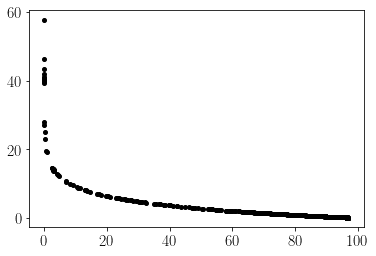

In [11]:
plt.plot(dfall['xmiss'],dfall['cX'],'k.')

In [26]:
df=dfall.copy(deep=True)
groupingvar='Date'
depthvar='prSM'
castvar='castid'
shallowLim=35
deepLim=60
critBath=150

In [50]:
y25=np.percentile(df.loc[(df.Date==20170531)&(df[depthvar]>=shallowLim)&(df[depthvar]<=deepLim)&\
                         (df.Bathy>=critBath)&(~np.isnan(df['xmiss'])),['xmiss']],25)
y25

94.59125092007707

In [42]:
y25=np.percentile(df.loc[(df.Date==20170531)&(df[depthvar]>=shallowLim)&(df[depthvar]<=deepLim)&\
                         (df.Bathy>=critBath)&(~np.isnan(df['xmiss'])),['xmiss']],25)
y75=np.percentile(df.loc[(df.Date==20170531)&(df[depthvar]>=shallowLim)&(df[depthvar]<=deepLim)&\
                         (df.Bathy>=critBath)&(~np.isnan(df['xmiss'])),['xmiss']],75)
df['xmiss_adj']=np.nan
for icr in np.unique(df[groupingvar]):
    idfcr=df.loc[(df[groupingvar]==icr)]
    # require station depth of at least critBath m to calculate offset
    idf_middep=idfcr.loc[(idfcr[depthvar]>=shallowLim)&(idfcr[depthvar]<=deepLim)&\
                         (idfcr.Bathy>=critBath)&(~np.isnan(idfcr['xmiss']))]
    x25=np.percentile(idf_middep['xmiss'],25)
    x75=np.percentile(idf_middep['xmiss'],75)
    m=(y75-y25)/(x75-x25)
    b=y75-m*x75
    print(m,b)
    castlist=np.unique(idfcr[castvar].values)
    for ii, ic in enumerate(castlist):
        ind=(df[groupingvar]==icr)&(df[castvar]==ic)
        df.loc[ind,['xmiss_adj']]=m*df.loc[ind,['xmiss']].values+b

2.04056142251119 -100.69864579627681
1.0 0.0
3.3948481489778013 -221.85093709962348


In [43]:
df['xmiss_adj']

0      -94.716275
1      -94.707804
2      -94.704977
3      -94.514148
4      -94.508608
          ...    
3033    82.828100
3034    84.012908
3035    78.443234
3036    76.651238
3037    63.482049
Name: xmiss_adj, Length: 3038, dtype: float64

In [44]:
df['cX_adj']=FRP.cXfromX(df['xmiss_adj'])

In [46]:
df['cX_adj']

0            NaN
1            NaN
2            NaN
3            NaN
4            NaN
          ...   
3033    0.753611
3034    0.696799
3035    0.971180
3036    1.063618
3037    1.817652
Name: cX_adj, Length: 3038, dtype: float64

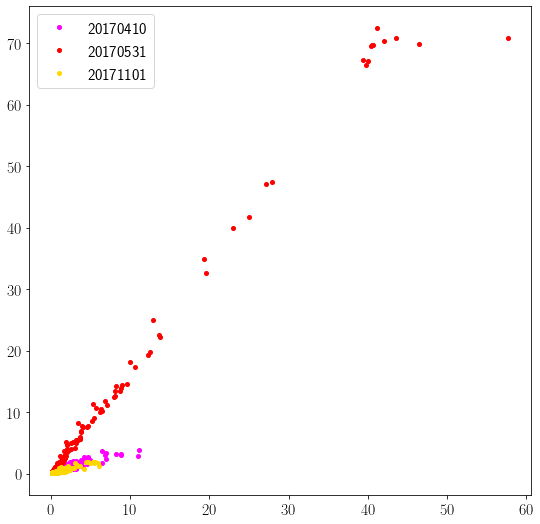

In [47]:
fig,ax=plt.subplots(1,1,figsize=(9,9))
cols='magenta','red','gold','green','turquoise','royalblue','blueviolet','purple'
ii=0
for idd in np.unique(dfall['Date']):
    ax.plot(df.loc[df.Date==idd,['cX_adj']],df.loc[df.Date==idd,['NTU']],'.',color=cols[ii],label=idd)
    ii+=1
ax.legend()

In [58]:
y50=np.percentile(df.loc[(df.Date==20170410)&(df[depthvar]>=shallowLim)&(df[depthvar]<=deepLim)&\
                         (df.Bathy>=critBath)&(~np.isnan(df['xmiss'])),['xmiss']],50)
df['xmiss_scA']=np.nan
for icr in np.unique(df[groupingvar]):
    idfcr=df.loc[(df[groupingvar]==icr)]
    # require station depth of at least critBath m to calculate offset
    idf_middep=idfcr.loc[(idfcr[depthvar]>=shallowLim)&(idfcr[depthvar]<=deepLim)&\
                         (idfcr.Bathy>=critBath)&(~np.isnan(idfcr['xmiss']))]
    x50=np.percentile(idf_middep['xmiss'],50)
    m=y50/x50
    castlist=np.unique(idfcr[castvar].values)
    for ii, ic in enumerate(castlist):
        ind=(df[groupingvar]==icr)&(df[castvar]==ic)
        df.loc[ind,['xmiss_scA']]=m*df.loc[ind,['xmiss']].values
df['cX_scA']=FRP.cXfromX(df['xmiss_scA'])

In [59]:
y50=np.percentile(df.loc[(df.Date==20170410)&(df[depthvar]>=shallowLim)&(df[depthvar]<=deepLim)&\
                         (df.Bathy>=critBath)&(~np.isnan(df['xmiss'])),['xmiss']],50)
df['xmiss_scB']=np.nan
for icr in np.unique(df[groupingvar]):
    idfcr=df.loc[(df[groupingvar]==icr)]
    # require station depth of at least critBath m to calculate offset
    idf_middep=idfcr.loc[(idfcr[depthvar]>=shallowLim)&(idfcr[depthvar]<=deepLim)&\
                         (idfcr.Bathy>=critBath)&(~np.isnan(idfcr['xmiss']))]
    x50=np.percentile(idf_middep['xmiss'],50)
    m=y50/x50
    castlist=np.unique(idfcr[castvar].values)
    for ii, ic in enumerate(castlist):
        ind=(df[groupingvar]==icr)&(df[castvar]==ic)
        df.loc[ind,['xmiss_scB']]=m*df.loc[ind,['xmiss']].values
df['cX_scB']=FRP.cXfromX(df['xmiss_scB'])

In [60]:
y50=np.percentile(df.loc[(df.Date==20171101)&(df[depthvar]>=shallowLim)&(df[depthvar]<=deepLim)&\
                         (df.Bathy>=critBath)&(~np.isnan(df['xmiss'])),['xmiss']],50)
df['xmiss_scC']=np.nan
for icr in np.unique(df[groupingvar]):
    idfcr=df.loc[(df[groupingvar]==icr)]
    # require station depth of at least critBath m to calculate offset
    idf_middep=idfcr.loc[(idfcr[depthvar]>=shallowLim)&(idfcr[depthvar]<=deepLim)&\
                         (idfcr.Bathy>=critBath)&(~np.isnan(idfcr['xmiss']))]
    x50=np.percentile(idf_middep['xmiss'],50)
    m=y50/x50
    castlist=np.unique(idfcr[castvar].values)
    for ii, ic in enumerate(castlist):
        ind=(df[groupingvar]==icr)&(df[castvar]==ic)
        df.loc[ind,['xmiss_scC']]=m*df.loc[ind,['xmiss']].values
df['cX_scC']=FRP.cXfromX(df['xmiss_scC'])

In [63]:
y50=np.percentile(df.loc[(df.Date==20171101)&(df[depthvar]>=shallowLim)&(df[depthvar]<=deepLim)&\
                         (df.Bathy>=critBath)&(~np.isnan(df['xmiss'])),['xmiss']],50)
df['xmiss_scC']=np.nan
for icr in np.unique(df[groupingvar]):
    idfcr=df.loc[(df[groupingvar]==icr)]
    # require station depth of at least critBath m to calculate offset
    idf_middep=idfcr.loc[(idfcr[depthvar]>=shallowLim)&(idfcr[depthvar]<=deepLim)&\
                         (idfcr.Bathy>=critBath)&(~np.isnan(idfcr['xmiss']))]
    x50=np.percentile(idf_middep['xmiss'],50)
    m=100/x50
    castlist=np.unique(idfcr[castvar].values)
    for ii, ic in enumerate(castlist):
        ind=(df[groupingvar]==icr)&(df[castvar]==ic)
        df.loc[ind,['xmiss_scD']]=m*df.loc[ind,['xmiss']].values
df['cX_scD']=FRP.cXfromX(df['xmiss_scD'])

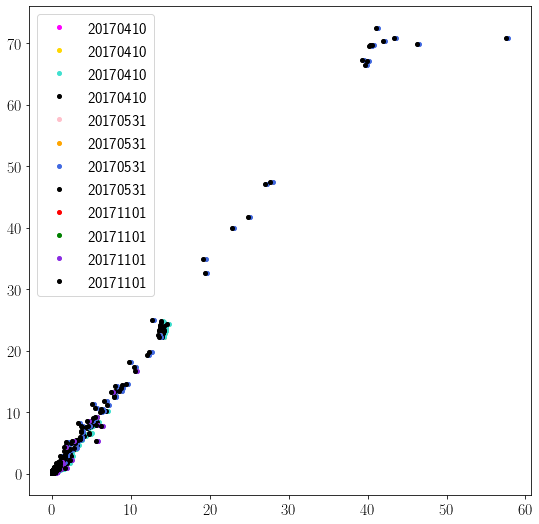

In [64]:
fig,ax=plt.subplots(1,1,figsize=(9,9))
cols='magenta','pink','red','gold','orange','green','turquoise','royalblue','blueviolet','purple'
ii=0
for idd in np.unique(dfall['Date']):
    ax.plot(df.loc[df.Date==idd,['cX_scA']],df.loc[df.Date==idd,['NTU']],'.',color=cols[ii],label=idd)
    ax.plot(df.loc[df.Date==idd,['cX_scB']],df.loc[df.Date==idd,['NTU']],'.',color=cols[ii+3],label=idd)
    ax.plot(df.loc[df.Date==idd,['cX_scC']],df.loc[df.Date==idd,['NTU']],'.',color=cols[ii+6],label=idd)
    ax.plot(df.loc[df.Date==idd,['cX_scD']],df.loc[df.Date==idd,['NTU']],'.',color='k',label=idd)
    ii+=1
ax.legend()

#### load STRATOGEM data:

In [9]:
dfXF=STRAT.loadSTRATOGEM_XFP(qc=True,calcs=['YD','cX'])

SG02-01 11/April/02 1.6227499999999964
SG02-02  8/May/02 -0.6704500000000024
SOG02-03 5/June/2002 -0.2139500000000112
SOG02-04 10/July/2002 0.5047999999999888
SOG02-05 17/July/2002 -0.03340000000000032
SOG02-06 07/August/2002 1.3174999999999955
SOG02-06 7/August/2002 8.0942
SOG02-07 29/Aug/2002 0.8496999999999986
SOG02-08 8/Oct/2002 1.842100000000002
SOG02-08 8/October/2002 1.5545999999999935
SOG02-09 5/Nov/2002 2.288749999999993
SOG02-10 4/Dec/2002 2.5351500000000016
SOG03-01 8/Jan/2003 1.9637500000000045
SOG03-02 5/Feb/2003 2.0537499999999937
SOG03-03 5/Mar/2003 5.672150000000002
SOG03-04 19/Mar/2003 7.4773
SOG03-05 2/Apr/2003 4.46905000000001
SOG03-06 9/Apr/2003 6.000550000000004
SOG03-07 16/Apr/2003 4.312150000000003
SOG03-08 23/Apr/2003 6.894599999999997
SOG03-09 28/May/2003 2.457250000000002
SOG03-10 19 /June/2003 3.2700999999999993
SOG03-11 23/June/2003 3.0463000000000022
SOG03-12 26 /June/2003 2.7757000000000005
SOG03-14 3 /July/2003 3.1513999999999953
SOG03-19 23/Sep/2003 3.07

### Both turbidity and beam attenuation show relationship to chlorophyll, but not necessarily the same relationship, so include chlorophyll in fit
- figure showing FRP turbidity vs chl, FRP beam attenuation vs chl, and STRATOGEM beam attenuation vs chl

In [10]:
ii=(~np.isnan(dfall['cX']))&(~np.isnan(dfall['wetStar']))&(~np.isnan(dfall['NTU']))
A=np.concatenate([dfall.loc[ii,['cX']].values,dfall.loc[ii,['wetStar']].values,np.ones((np.sum(ii),1))],1)
b=dfall.loc[ii,['NTU']].values
m,res2sum,p,n,cov,CI,Rsq = pf.lsqfit(A,b)
print(m)
print(m-CI)
print(m+CI)
#turbfit=m

[ 2.95947227 -0.13883349  0.17954807]
[ 2.90662781 -0.16140935  0.1054726 ]
[ 3.01231674 -0.11625764  0.25362354]


In [11]:
ii=(~np.isnan(dfall['cX']))&(~np.isnan(dfall['wetStar']))&(~np.isnan(dfall['NTU']))
A=np.concatenate([dfall.loc[ii,['wetStar']].values,np.ones((np.sum(ii),1))],1)
b=dfall.loc[ii,['NTU']].values
m,res2sum,p,n,cov,CI,Rsq = pf.lsqfit(A,b)
print(m)
print(m-CI)
print(m+CI)
#turbfit=m

[0.1489218  0.50604004]
[0.09923702 0.33914076]
[0.19860659 0.67293933]


In [12]:
import scipy.stats as sst

In [13]:
sst.chi2.ppf(.95, 2, loc=0, scale=1)

5.991464547107979

In [14]:
def LL(n,res2sum):
    return -1/2*np.log(2*np.pi)-n/2*np.log(res2sum/n)-1/(2*res2sum/n)*res2sum

In [15]:
LL(n,Rsq)

16797.52271381331

#### regression: beam attenuation on chl --- FRP

In [16]:
## all data
ii=(~np.isnan(dfall['cX']))&(~np.isnan(dfall['wetStar']))#&(~np.isnan(dfall['NTU']))
A=np.concatenate([dfall.loc[ii,['wetStar']].values,np.ones((np.sum(ii),1))],1)
b=dfall.loc[ii,['cX']].values
m,res2sum,p,n,cov,CI,Rsq = pf.lsqfit(A,b)
print(m)
print(m-CI)
print(m+CI)
m_cXFRP=m
CI_cXFRP=CI

[0.09808494 0.1105664 ]
[0.08303296 0.06006865]
[0.11313691 0.16106416]


In [17]:
## bin in x and take bottom n% of values y values
ii=(~np.isnan(dfall['cX']))&(~np.isnan(dfall['wetStar']))#&(~np.isnan(dfall['NTU']))
df2=dfall.loc[ii]

wbin=0.5
bins=np.arange(0,60,wbin)

A=np.concatenate([dfall.loc[ii,['wetStar']].values,np.ones((np.sum(ii),1))],1)
b=dfall.loc[ii,['cX']].values
m,res2sum,p,n,cov,CI,Rsq = pf.lsqfit(A,b)
print(m)
print(m-CI)
print(m+CI)
m_cXFRP=m
CI_cXFRP=CI

[0.09808494 0.1105664 ]
[0.08303296 0.06006865]
[0.11313691 0.16106416]


#### regression: beam attenuation on chl --- STRATOGEM

In [18]:
ii=(~np.isnan(dfXF['cX']))&(~np.isnan(dfXF['wetStar']))
A=np.concatenate([dfXF.loc[ii,['wetStar']].values,np.ones((np.sum(ii),1))],1)
b=dfXF.loc[ii,['cX']].values
m,res2sum,p,n,cov,CI,Rsq = pf.lsqfit(A,b)
print(m)
print(m-CI)
print(m+CI)
m_cXSTR=m
CI_cXSTR=CI

[0.05139407 0.05915414]
[0.05073071 0.05659893]
[0.05205742 0.06170934]


-0.060536795020623674 -0.17821050819623502
1.0991647078257618 -1.4206


Text(0.5, 1.0, 'Sal $>$ 27 and upper 10 m for Strat, turb<.5 for FRP')

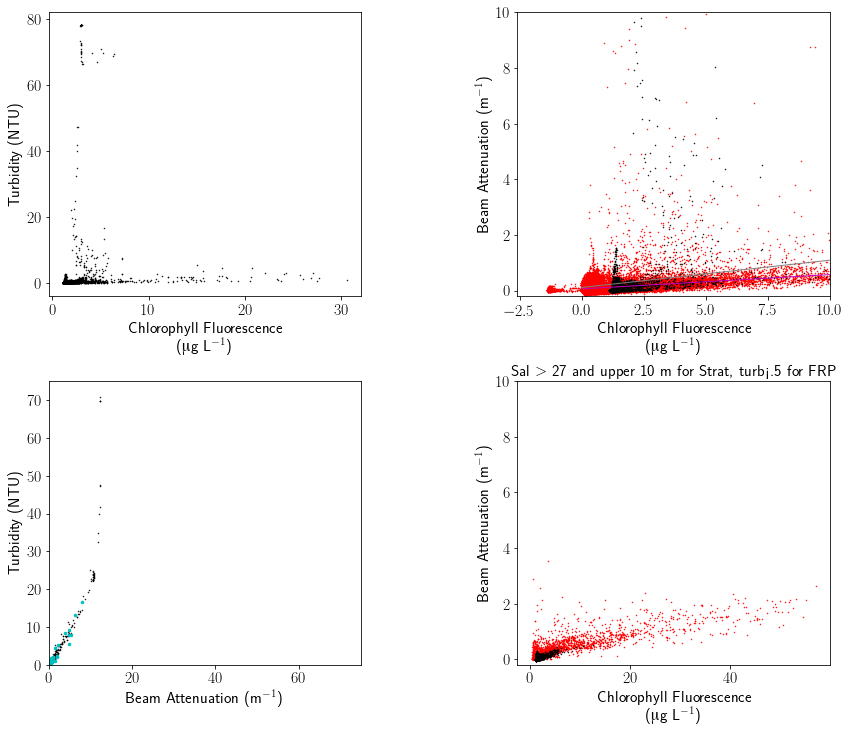

In [19]:
fig=plt.figure(figsize=(14,12))
fig.subplots_adjust(hspace=.3)
gs=gridspec.GridSpec(ncols=2,nrows=2,figure=fig,wspace=.5)#left,right,top,bottom,wspace,hspace,width_ratios,height_ratios
ax0=fig.add_subplot(gs[0])
ax1=fig.add_subplot(gs[1])
ax2=fig.add_subplot(gs[2])
ax3=fig.add_subplot(gs[3])
ax0.plot(dfall['wetStar'],dfall['NTU'],'k.',ms=1)
ax0.set_xlabel('Chlorophyll Fluorescence\n($\muup$g L$^{-1}$)')
ax0.set_ylabel('Turbidity (NTU)')
ax1.plot(dfXF['wetStar'],dfXF['cX'],'r.',ms=1)
ax1.set_xlabel('Chlorophyll Fluorescence\n($\muup$g L$^{-1}$)')
ax1.set_ylabel('Beam Attenuation (m$^{-1}$)')
ax1.plot(dfall['wetStar'],dfall['cX'],'k.',ms=1)
ax1.set_xlim(-2.6,10)
ax1.set_ylim(-.2,10)
ff=np.arange(0,60)
ax1.plot(ff,m_cXFRP[0]*ff+m_cXFRP[1],'-',color='gray')
ax1.plot(ff,m_cXSTR[0]*ff+m_cXSTR[1],'-',color='m')
ax2.plot(dfall['cX'],dfall['NTU'],'k.',ms=1)
#ax2.plot(dfall['cX'],dfall['NTU']+0.03701983*dfall['wetStar'],'r.',ms=1)
ii=dfall.Date==20171101
ax2.plot(dfall.loc[ii,['cX']].values,dfall.loc[ii,['NTU']].values,'c.',ms=5)
ax2.set_xlabel('Beam Attenuation (m$^{-1}$)')
ax2.set_ylabel('Turbidity (NTU)')
ax2.set_xlim(0,75)
ax2.set_ylim(0,75)
#ax3.plot(dfall['cX']-??*dfall['wetStar'])
print(np.min(dfall['cX']),np.min(dfXF['cX']))
print(np.min(dfall['wetStar']),np.min(dfXF['wetStar']))
# try high salinity points:
tsal=27
tz=10
dfXF2=dfXF.loc[(dfXF['sal00']>tsal)&(dfXF['prSM']<tz)] #! probably need to convert sal00
ax3.plot(dfXF2['wetStar'],dfXF2['cX'],'r.',ms=1)
#dfall2=dfall.loc[(dfall['gsw_srA0']>tsal)&(dfall['prSM']<tz)]
dfall2=dfall.loc[(dfall['NTU']<.5)]
ax3.set_xlabel('Chlorophyll Fluorescence\n($\muup$g L$^{-1}$)')
ax3.set_ylabel('Beam Attenuation (m$^{-1}$)')
ax3.plot(dfall2['wetStar'],dfall2['cX'],'k.',ms=1)
#ax3.set_xlim(-2.6,10)
ax3.set_ylim(-.2,10)
ax3.set_title(f'Sal $>$ {tsal} and upper {tz} m for Strat, turb<.5 for FRP')

In [20]:
dfall.loc[(dfall['cX']<5)&(dfall['wetStar']>5)]

,prSM,gsw_ctA0,gsw_srA0,xmiss,par,wetStar,sbeox0ML_L,seaTurbMtrnoQC,turb_uncor,NTU,...,wetStar19,isup,sta,castid,Station,Date,Lat,Lon,Bathy,cX
24,1.0,8.591339,25.983465,73.062169,232.523852,14.536400,7.305039,52.870801,52.738954,1.710018,...,33.487374,1,3.0,5,3.0,20170410,49.099983,-123.526600,314.6250,1.255438
25,2.0,8.557910,26.414945,75.808050,131.630196,15.681238,7.165835,47.652456,46.806962,1.517678,...,35.341167,1,3.0,5,3.0,20170410,49.099983,-123.526600,314.6250,1.107863
26,3.0,8.522449,26.888488,80.271246,82.128816,14.384032,6.900959,39.415372,38.962323,1.263322,...,33.188858,1,3.0,5,3.0,20170410,49.099983,-123.526600,314.6250,0.879035
27,4.0,8.497187,27.079040,83.512909,49.716912,9.798991,6.563529,34.355847,34.331376,1.113167,...,20.122387,1,3.0,5,3.0,20170410,49.099983,-123.526600,314.6250,0.720676
28,5.0,8.477757,27.672911,89.077674,33.625905,6.364046,6.185958,28.296127,27.396218,0.888300,...,11.499446,1,3.0,5,3.0,20170410,49.099983,-123.526600,314.6250,0.462646
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2796,5.0,10.611450,28.081865,93.575980,5.003012,5.225239,5.676211,17.688295,18.238866,0.591380,...,10.184444,0,22.0,44,22.0,20171101,49.099883,-123.350233,152.1875,0.265586
2890,1.0,10.570075,26.485871,70.138921,76.101768,5.157949,6.090350,139.011138,134.005639,4.345023,...,11.180448,1,23.0,45,23.0,20171101,49.100400,-123.324583,72.3750,1.418769
2955,3.0,10.621759,28.046196,82.334436,15.645509,5.136248,5.862336,20.460478,20.963123,0.679712,...,9.852009,0,23.0,46,23.0,20171101,49.100400,-123.324583,72.3750,0.777523
2956,4.0,10.624016,28.397759,89.510976,12.412511,5.321041,5.209919,12.417587,12.529698,0.406265,...,9.545542,0,23.0,46,23.0,20171101,49.100400,-123.324583,72.3750,0.443236


(0.0, 75.0)

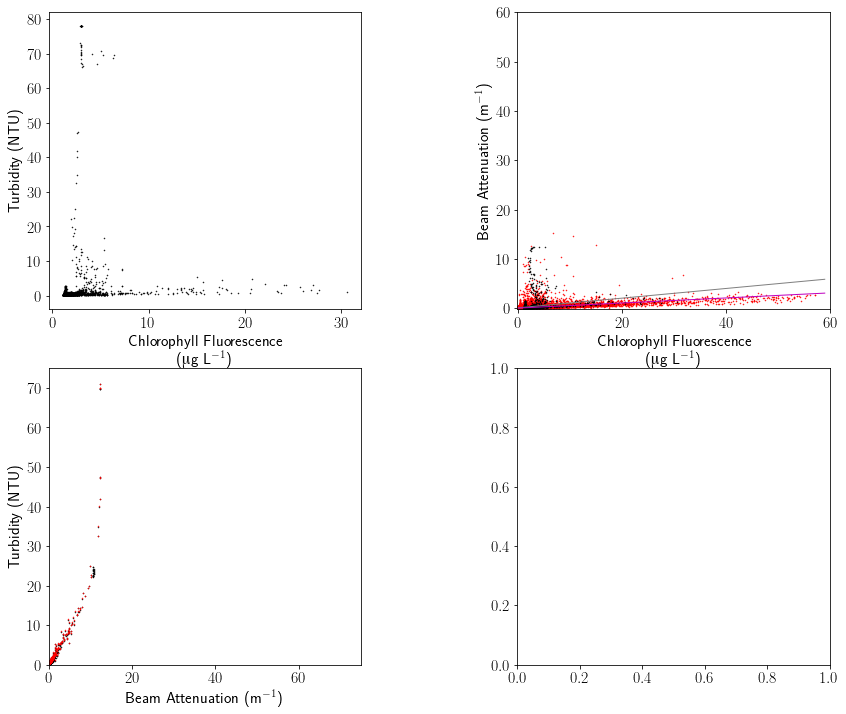

In [21]:
fig=plt.figure(figsize=(14,12))
gs=gridspec.GridSpec(ncols=2,nrows=2,figure=fig,wspace=.5)#left,right,top,bottom,wspace,hspace,width_ratios,height_ratios
ax0=fig.add_subplot(gs[0])
ax1=fig.add_subplot(gs[1])
ax2=fig.add_subplot(gs[2])
ax3=fig.add_subplot(gs[3])
ax0.plot(dfall['wetStar'],dfall['NTU'],'k.',ms=1)
ax0.set_xlabel('Chlorophyll Fluorescence\n($\muup$g L$^{-1}$)')
ax0.set_ylabel('Turbidity (NTU)')
ax1.plot(dfXF['wetStar'],dfXF['cX'],'r.',ms=1)
ax1.set_xlabel('Chlorophyll Fluorescence\n($\muup$g L$^{-1}$)')
ax1.set_ylabel('Beam Attenuation (m$^{-1}$)')
ax1.plot(dfall['wetStar'],dfall['cX'],'k.',ms=1)
ax1.set_xlim(-.1,60)
ax1.set_ylim(-.1,60)
ff=np.arange(0,60)
ax1.plot(ff,m_cXFRP[0]*ff+m_cXFRP[1],'-',color='gray')
ax1.plot(ff,m_cXSTR[0]*ff+m_cXSTR[1],'-',color='m')
ax2.plot(dfall['cX'],dfall['NTU'],'k.',ms=1)
ax2.plot(dfall['cX'],dfall['NTU']+0.03701983*dfall['wetStar'],'r.',ms=1)
ax2.set_xlabel('Beam Attenuation (m$^{-1}$)')
ax2.set_ylabel('Turbidity (NTU)')
ax2.set_xlim(0,75)
ax2.set_ylim(0,75)
#ax3.plot(dfall['cX']-??*dfall['wetStar'])

### Fit based on FRP data:

In [22]:
# linear fit: turb = a * cI + b * chl + c
ii=(~np.isnan(dfall['cX']))&(~np.isnan(dfall['NTU']))&(~np.isnan(dfall['wetStar']))
X=np.vstack([dfall.loc[ii]['cX'],dfall.loc[ii]['wetStar'],np.ones(len(dfall.loc[ii]['wetStar']))]).T
y=dfall.loc[ii]['NTU']
b,res,d,n,cov,CI,Rsq=pf.lsqfit(X,y)
print('b:',b,'CI:',CI)
print('R**2=',Rsq)

b: [ 2.95947227 -0.13883349  0.17954807] CI: [0.05284447 0.02257585 0.07407547]
R**2= 0.8065751178611967


In [23]:
ii=(~np.isnan(dfall['cX']))&(~np.isnan(dfall['wetStar']))&(dfall['cX']<4.0)&(dfall['wetStar']>10)
X=np.vstack([dfall.loc[ii]['wetStar'],np.ones(len(dfall.loc[ii]['wetStar']))]).T
y=dfall.loc[ii]['cX']
b,res,d,n,cov,CI,Rsq=pf.lsqfit(X,y)
print('b:',b,'CI:',CI)
print('R**2=',Rsq)

b: [0.0446733  0.47687437] CI: [0.02763155 0.49094155]
R**2= 0.15066271697275258


In [24]:
ii=(~np.isnan(dfXF['cX']))&(~np.isnan(dfXF['wetStar']))&(dfXF['cX']<4.0)&(dfXF['wetStar']>10)
X=np.vstack([dfXF.loc[ii]['wetStar'],np.ones(len(dfXF.loc[ii]['wetStar']))]).T
y=dfXF.loc[ii]['cX']
b,res,d,n,cov,CI,Rsq=pf.lsqfit(X,y)
print('b:',b,'CI:',CI)
print('R**2=',Rsq)

b: [0.03727208 0.28934456] CI: [0.00224888 0.05282842]
R**2= 0.4475381924847911


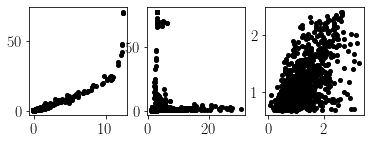

In [25]:
fig=plt.figure(figsize=(6,2))
gs=gridspec.GridSpec(ncols=3,nrows=1,figure=fig)#left,right,top,bottom,wspace,hspace,width_ratios,height_ratios
ax0=fig.add_subplot(gs[0])
ax1=fig.add_subplot(gs[1])
ax2=fig.add_subplot(gs[2])
ax0.plot(dfall['cX'],dfall['NTU'],'k.')
ax1.plot(dfall['wetStar'],dfall['NTU'],'k.')
ax2.plot(y,np.dot(X,b),'k.')

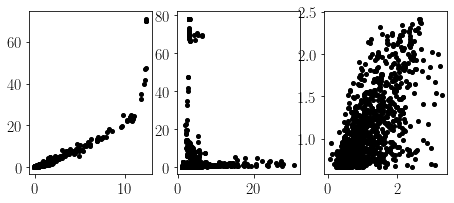

In [26]:
fig=plt.figure(figsize=(7.5,3))
gs=gridspec.GridSpec(ncols=3,nrows=1,figure=fig)#left,right,top,bottom,wspace,hspace,width_ratios,height_ratios
ax0=fig.add_subplot(gs[0])
ax1=fig.add_subplot(gs[1])
ax2=fig.add_subplot(gs[2])
ax0.plot(dfall['cX'],dfall['NTU'],'k.')
ax1.plot(dfall['wetStar'],dfall['NTU'],'k.')
ax2.plot(y,np.dot(X,b),'k.')